In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
path_template="/content/drive/MyDrive/Colab Notebooks/Vision por computadora 1/template/pattern.png"
path_image1="/content/drive/MyDrive/Colab Notebooks/Vision por computadora 1/Images/coca_retro_1.png"
path_image2="/content/drive/MyDrive/Colab Notebooks/Vision por computadora 1/Images/coca_retro_2.png"
path_image3="/content/drive/MyDrive/Colab Notebooks/Vision por computadora 1/Images/coca_logo_1.png"
path_image4="/content/drive/MyDrive/Colab Notebooks/Vision por computadora 1/Images/coca_logo_2.png"
path_image5="/content/drive/MyDrive/Colab Notebooks/Vision por computadora 1/Images/COCA-COLA-LOGO.jpg"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def preprocesar_imagen(imagen):
    # Convertir a escala de grises
    imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Aplicar suavizado con filtro Gaussiano
    imagen = cv2.GaussianBlur(imagen, (3, 3), 0)

    # Binarización con umbral adaptativo
    _, imagen = cv2.threshold(imagen, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Aplicar Canny Edge Detection
    imagen = cv2.Canny(imagen, 100, 200)

    return imagen

In [3]:
def supresion_no_maximos(detecciones, scores, umbral):
    detecciones_finales = []

    # Ordenar las detecciones por sus puntuaciones
    indices = np.argsort(scores)[::-1]

    while len(indices) > 0:
        # Tomar la detección con la puntuación más alta
        max_idx = indices[0]
        deteccion_max = detecciones[max_idx]

        # Agregar la detección a la lista de detecciones finales
        detecciones_finales.append(deteccion_max)

        # Calcular la intersección sobre la unión (IoU) entre la detección máxima y las demás detecciones
        ious = np.array([calcular_iou(deteccion_max, detecciones[idx]) for idx in indices[1:]])

        # Mantener solo las detecciones que tienen un IoU menor que el umbral
        indices = indices[1:][ious < umbral]

    return detecciones_finales

In [4]:
def calcular_iou(caja1, caja2):
    x1 = max(caja1[0], caja2[0])
    y1 = max(caja1[1], caja2[1])
    x2 = min(caja1[2], caja2[2])
    y2 = min(caja1[3], caja2[3])

    interseccion = max(0, x2 - x1) * max(0, y2 - y1)
    area_caja1 = (caja1[2] - caja1[0]) * (caja1[3] - caja1[1])
    area_caja2 = (caja2[2] - caja2[0]) * (caja2[3] - caja2[1])

    iou = interseccion / (area_caja1 + area_caja2 - interseccion)
    return iou

In [8]:
def detectar_coincidencias(template_path, imagenes_paths):
    # Cargar la plantilla
    template = cv2.imread(template_path, 0)

    for imagen_path in imagenes_paths:
        # Cargar la imagen
        imagen = cv2.imread(imagen_path, 0)

        # Verificar el tamaño de la imagen en comparación con la plantilla
        if imagen.shape[0] > template.shape[0] or imagen.shape[1] > template.shape[1]:
            # Redimensionar la imagen para que tenga el mismo tamaño que la plantilla
            imagen = cv2.resize(imagen, (template.shape[1], template.shape[0]))

        # Crear pirámides de imágenes y plantillas
        piramide_imagen = [imagen]
        piramide_template = [template]

        # Generar la pirámide de imágenes
        while len(piramide_imagen) < 4:
            imagen_previa = piramide_imagen[-1]
            imagen_reducida = cv2.pyrDown(imagen_previa)
            piramide_imagen.append(imagen_reducida)

        # Generar la pirámide de plantillas
        while len(piramide_template) < len(piramide_imagen):
            template_previa = piramide_template[-1]
            template_reducida = cv2.pyrDown(template_previa)
            piramide_template.append(template_reducida)

        # Inicializar una lista para almacenar las detecciones
        detecciones = []

        # Recorrer las escalas de la pirámide de imágenes
        for i, escala_imagen in enumerate(piramide_imagen):
            # Obtener la escala correspondiente de la pirámide de plantillas
            escala_template = piramide_template[i]

            # Realizar la correlación de plantillas
            resultado = cv2.matchTemplate(escala_imagen, escala_template, cv2.TM_CCOEFF_NORMED)

            # Definir un umbral para la coincidencia
            umbral = 0.5

            # Encontrar las posiciones donde la correlación es mayor que el umbral
            coincidencias = np.where(resultado >= umbral)

            # Obtener las coordenadas de las detecciones en la escala original
            for pt in zip(*coincidencias[::-1]):
                x = pt[0] * (2 ** i)
                y = pt[1] * (2 ** i)
                w = escala_template.shape[1] * (2 ** i)
                h = escala_template.shape[0] * (2 ** i)

                detecciones.append([x, y, x + w, y + h])

        # Convertir las detecciones a un array numpy
        detecciones = np.array(detecciones)

        # Aplicar supresión de no máximos para eliminar detecciones superpuestas
        puntajes = np.ones(len(detecciones))
        detecciones_filtradas = supresion_no_maximos(detecciones, puntajes, umbral=0.1)

        # Dibujar rectángulos alrededor de las detecciones
        imagen_color = cv2.cvtColor(imagen, cv2.COLOR_GRAY2BGR)
        for detection in detecciones_filtradas:
            x1, y1, x2, y2 = detection.astype(np.int32)
            cv2.rectangle(imagen_color, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Mostrar la imagen resultante
        plt.imshow(imagen_color)
        plt.axis('off')
        plt.show()


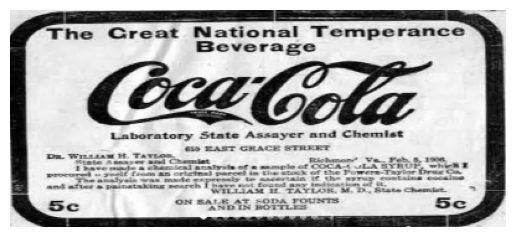

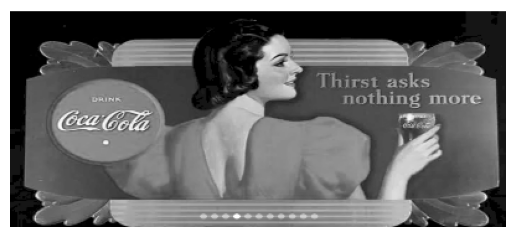

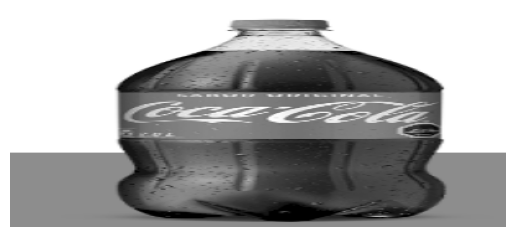

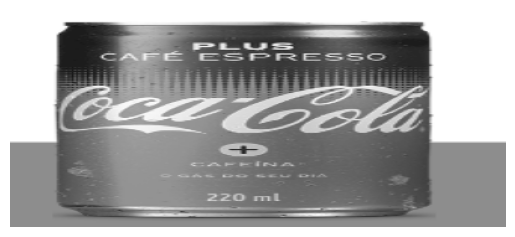

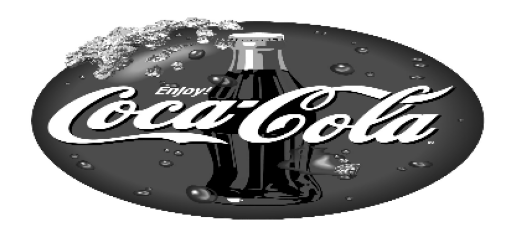

In [9]:
# Ruta del template y las imágenes a comparar
template_path = path_template
imagenes_paths = [path_image1, path_image2, path_image3, path_image4, path_image5 ]

detectar_coincidencias(template_path, imagenes_paths)